# Meteorologie hautnah – Mobile Stadtklimamessungen als Citizen Science-Projekt
*Oscar Ritter und Johannes Röttenbacher*

Inhalt:
- 2 Gruppen getrennt plotten (Zeitreihe, T und delta T zu Holzhausen, Taupunkt)
- Unterschied nach android/Iphone
- Karte mit Temperaturmessungen
- Zeitreihe Holzhausen dazupacken
- Interpolieren der Messwerte auf Gitter 10mx10m 5minuten Mittel (optional sonst komplett Mittel)


In [46]:
%matplotlib inline
# import modules
import os

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cmasher as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from wetterdienst import Resolution
from wetterdienst.provider.dwd.observation import DwdObservationRequest, DwdObservationDataset

import meteohautnah.meteohautnah as mh


In [47]:
# define a function to retrieve station data from the DWD network
def station_temp(name, start_date, end_date):
    request = DwdObservationRequest(parameter=DwdObservationDataset.TEMPERATURE_AIR,
                                    resolution=Resolution.MINUTE_10,
                                    start_date=start_date,
                                    end_date=end_date,
                                    ).filter_by_name(name=name)

    df = request.values.all().df
    df = df.to_pandas()
    df_t = df[df['parameter'] == "temperature_air_mean_200"].drop(['dataset', 'parameter', 'quality'], axis=1)
    df_t.rename(columns={'value': 'air_temperature'}, inplace=True)
    df_dew = df[df.parameter == "temperature_dew_point_mean_200"].drop(
        ['station_id', 'dataset', 'parameter', 'quality'], axis=1)

    df_dew.rename(columns={'value': 'dewpoint'}, inplace=True)

    df_t.set_index(pd.DatetimeIndex(df_t['date']), inplace=True)
    df_dew.set_index(pd.DatetimeIndex(df_t['date']), inplace=True)

    df_out = df_t.merge(df_dew, how='left', left_index=True, right_index=True)
    df_out["time"] = pd.to_datetime(df_t.date, format="%Y-%m-%d %H:%M:%S%z").dt.tz_localize(None)
    df_out = df_out.drop(["date_x", "date_y"], axis=1)
    df_out['air_temperature'] = df_out['air_temperature'] - 273.15
    df_out['dewpoint'] = df_out['dewpoint'] - 273.15

    return df_out


In [48]:
# set paths
base_path = 'C:/Users/Johannes/Documents/MeteorologieHautnah/MeteorologieHautnah'
data_path = f'{base_path}/Daten/processed'
plot_path = f'{base_path}/Daten/plots/stumeta'
os.makedirs(plot_path, exist_ok=True)

In [61]:
group1 = ['04', '05', '06', '07', '08', 'MT2', 'MT5', 'MT9', ]
group2 = ['10']
iphones = ['04', '05']
android = ['06', '07', '10']

In [62]:
# read in and filter data
device_ids = pd.read_csv(f'{base_path}/Daten/device_ids.txt',
                         skipinitialspace=True,
                         )
g1 = device_ids['MAC-address'][device_ids["number"].isin(group1)]
g2 = device_ids['MAC-address'][device_ids["number"].isin(group2)]
device_ids.rename(columns={'MAC-address': 'device_id',
                           'number': 'Nummer'},
                  inplace=True)

In [63]:
df = mh.read_data(data_path,
                  date='2024-05-05',
                  speedfilter=10)
df['Gruppe'] = np.where(df['device_id'].isin(g1), 1, 2)
df = df.merge(device_ids, on='device_id', how='left')


In [64]:
# add a column with the operating system
df['os'] = np.where(df['Nummer'].isin(android), 'Android', 'iOS')

## Zeitreihen der beiden Gruppen
### Lufttemperatur

C:\Users\Johannes\AppData\Local\Temp\ipykernel_12956\346759955.py:3: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.lineplot(data=df, x='time', y='air_temperature', ax=ax,


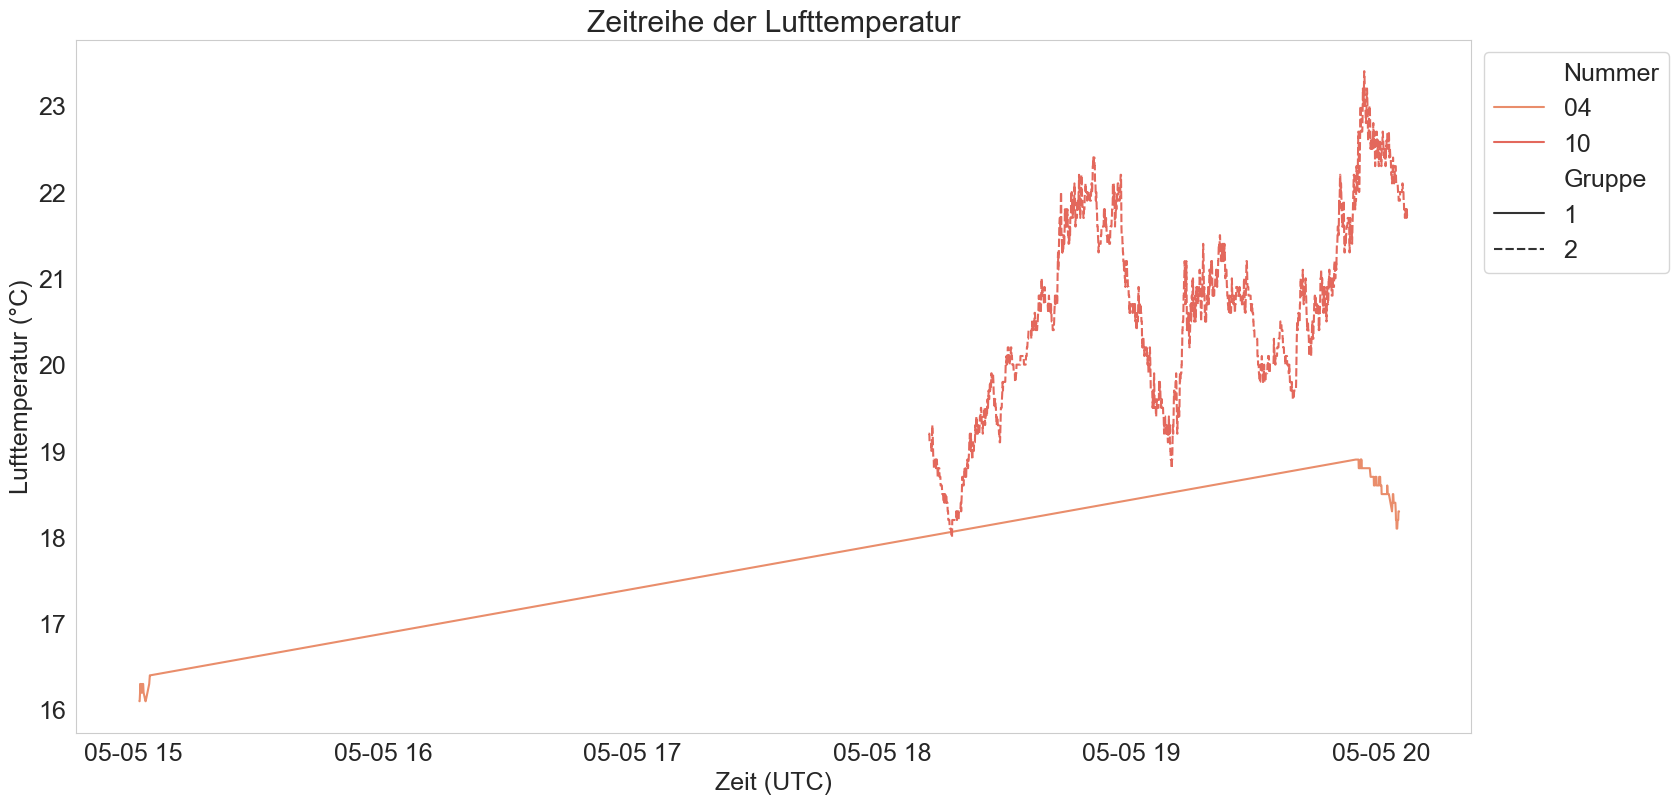

In [65]:
plt.rc('font', size=18)
_, ax = plt.subplots(figsize=(18, 9))
sns.lineplot(data=df, x='time', y='air_temperature', ax=ax,
             hue='Nummer', style='Gruppe', palette=sns.color_palette('flare'))
ax.set(
    title='Zeitreihe der Lufttemperatur',
    xlabel='Zeit (UTC)',
    ylabel='Lufttemperatur (°C)',
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.grid()
plt.show()


### Taupunkt

C:\Users\Johannes\AppData\Local\Temp\ipykernel_12956\2941136825.py:3: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.lineplot(data=df, x='time', y='dewpoint', ax=ax,
C:\Users\Johannes\AppData\Local\Temp\ipykernel_12956\2941136825.py:6: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.lineplot(data=df, x='time', y='air_temperature', ax=ax,


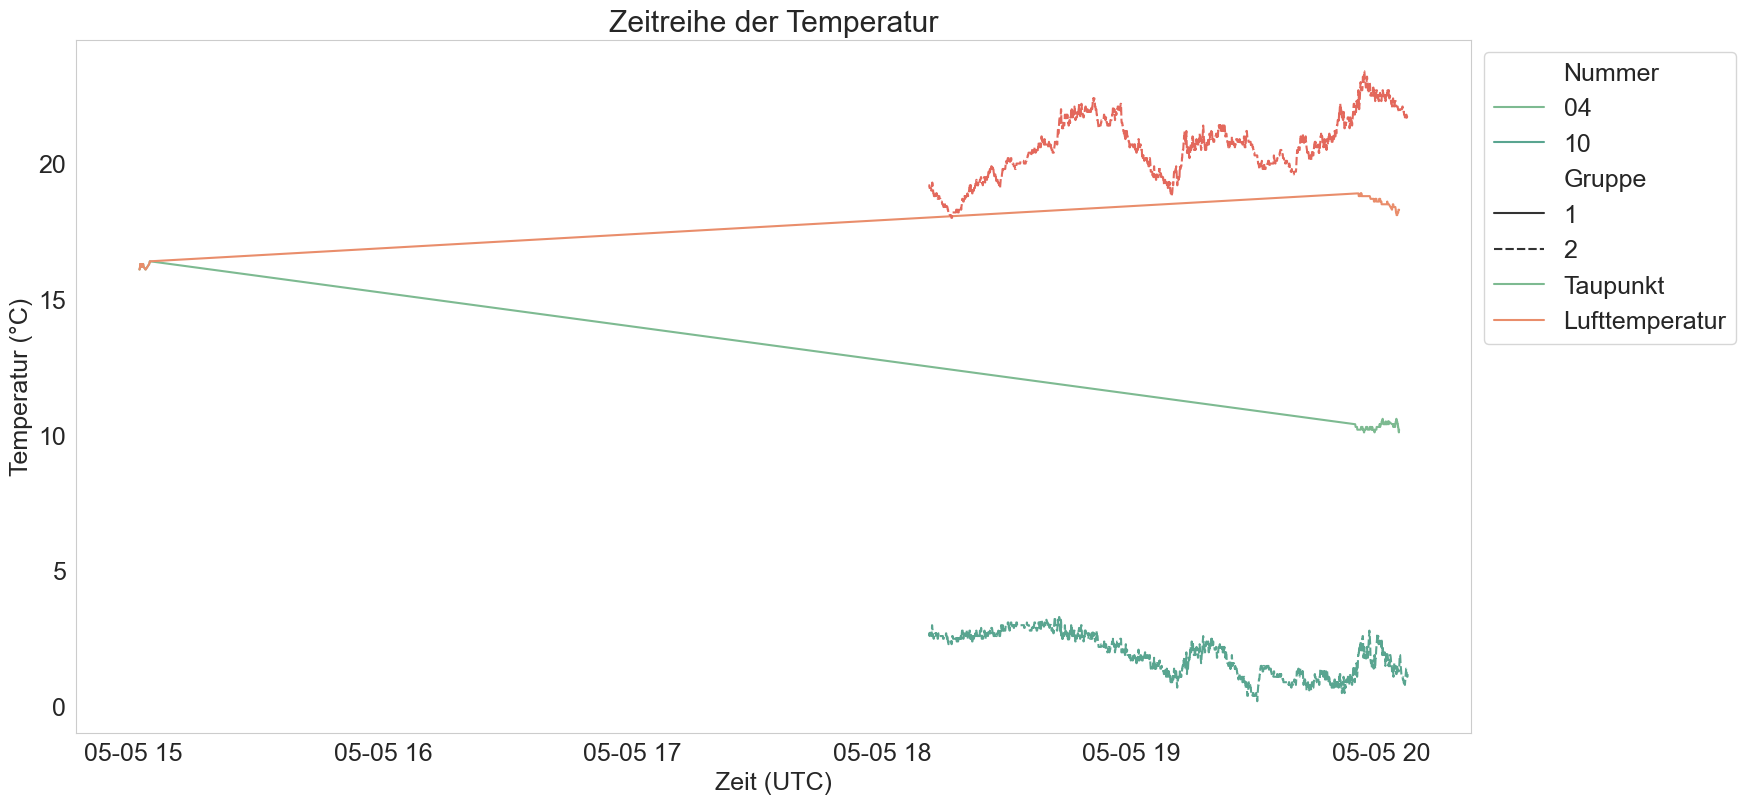

In [66]:
plt.rc('font', size=18)
_, ax = plt.subplots(figsize=(18, 9))
sns.lineplot(data=df, x='time', y='dewpoint', ax=ax,
             hue='Nummer', style='Gruppe', palette=sns.color_palette('crest'),
             )
sns.lineplot(data=df, x='time', y='air_temperature', ax=ax,
             hue='Nummer', style='Gruppe', legend=False,
             palette=sns.color_palette('flare')
             )
ax.set(
    title='Zeitreihe der Temperatur',
    xlabel='Zeit (UTC)',
    ylabel='Temperatur (°C)',
)

# make dummy for legend
ax.plot([], color=sns.color_palette('crest')[0], ls='-', label='Taupunkt')
ax.plot([], color=sns.color_palette('flare')[0], ls='-', label='Lufttemperatur')
ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.grid()
plt.show()
plt.close()

## Karte mit Messpunkten

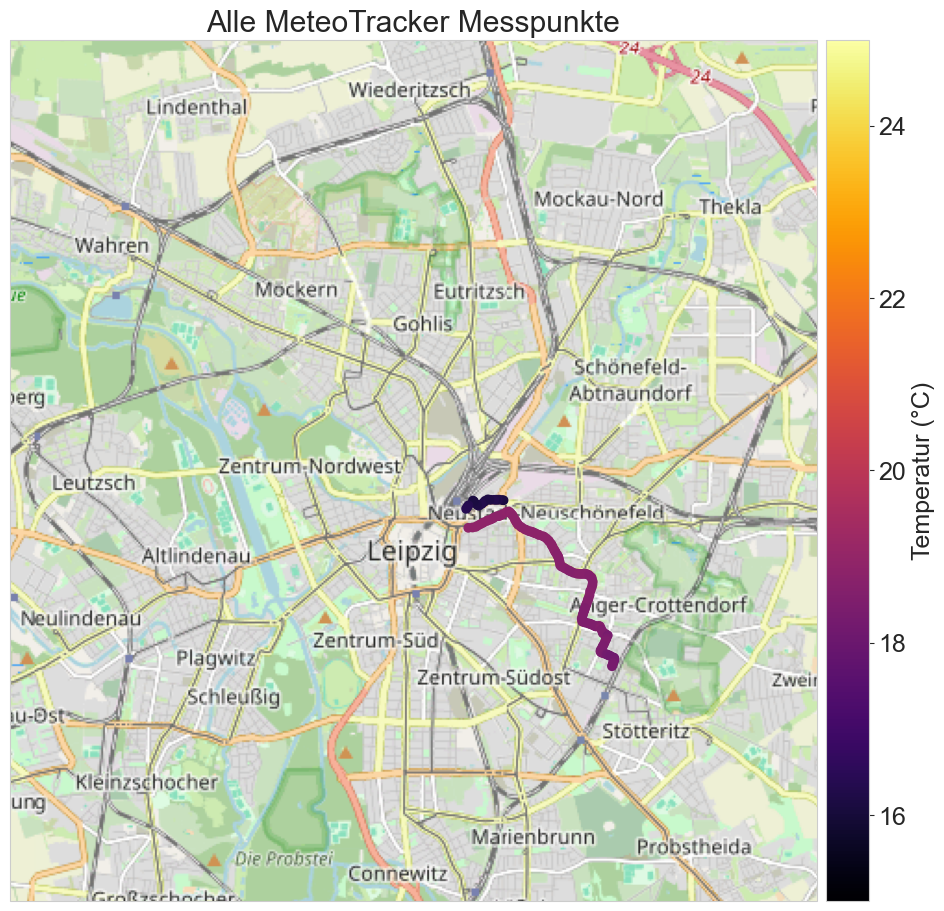

In [67]:
plot_df1 = df[df['Gruppe'] == 1]
plot_df2 = df[df['Gruppe'] == 2]
request = cimgt.OSM()
_, ax = plt.subplots(figsize=(10, 9),
                     subplot_kw=dict(projection=request.crs),
                     layout='constrained')
# extent = [12.2, 12.55, 51.16, 51.45]  # (xmin, xmax, ymin, ymax)
extent = [12.3, 12.45, 51.30, 51.4]  # (xmin, xmax, ymin, ymax)
ax.set_extent(extent)
ax.add_image(request, 12)
scatter = ax.scatter(plot_df1['lon'], plot_df1['lat'],
                     c=plot_df1['air_temperature'],
                     transform=ccrs.Geodetic(),
                     cmap='inferno', vmin=15, vmax=25,
                     marker='o')
ax.scatter(plot_df2['lon'], plot_df2['lat'],
           c=plot_df2['air_temperature'],
           transform=ccrs.Geodetic(),
           cmap='inferno', vmin=15, vmax=25,
           marker='x')
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.01,
                    label='Temperatur (°C)')
ax.set_title('Alle MeteoTracker Messpunkte')
# plt.savefig(f'{plot_path}/alle_messungen_juli.png', dpi=300, transparent=True)
plt.show()


## Vergleich zur DWD Station Holzhausen

In [68]:
df_dwd = station_temp(name='Leipzig-Holzhausen',
                      start_date='2024-05-05',
                      end_date='2024-05-06')
df_dwd.reset_index(drop=True, inplace=True)

In [69]:
df_dwd['device_id'] = 'DWD'
df_dwd['Gruppe'] = 'DWD'
df_dwd['Nummer'] = 'DWD'
df_dwd['time'] = df_dwd.time.dt.tz_localize('Europe/Berlin')
df = pd.concat([df, df_dwd])

C:\Users\Johannes\AppData\Local\Temp\ipykernel_12956\4153247800.py:3: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.lineplot(data=df, x='time', y='dewpoint', ax=ax,
C:\Users\Johannes\AppData\Local\Temp\ipykernel_12956\4153247800.py:6: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.lineplot(data=df, x='time', y='air_temperature', ax=ax,


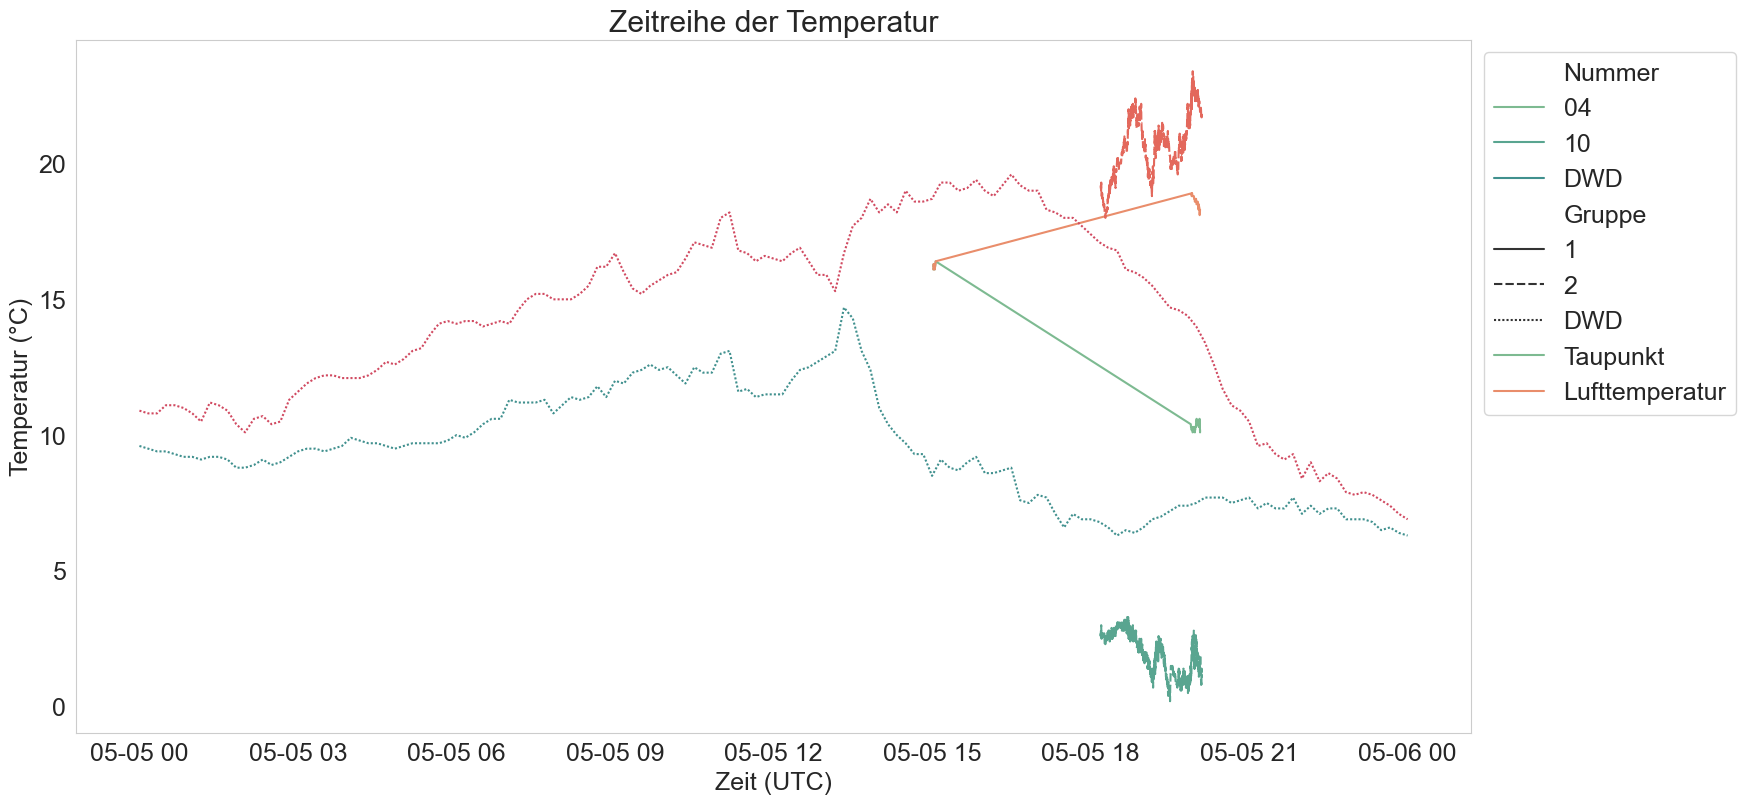

In [70]:
plt.rc('font', size=18)
_, ax = plt.subplots(figsize=(18, 9))
sns.lineplot(data=df, x='time', y='dewpoint', ax=ax,
             hue='Nummer', style='Gruppe', palette=sns.color_palette('crest'),
             )
sns.lineplot(data=df, x='time', y='air_temperature', ax=ax,
             hue='Nummer', style='Gruppe', legend=False,
             palette=sns.color_palette('flare'))
ax.set(
    title='Zeitreihe der Temperatur',
    xlabel='Zeit (UTC)',
    ylabel='Temperatur (°C)',
)
# make dummy for legend
ax.plot([], color=sns.color_palette('crest')[0], ls='-', label='Taupunkt')
ax.plot([], color=sns.color_palette('flare')[0], ls='-', label='Lufttemperatur')
ax.legend()
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.grid()
plt.show()

## Heatmap

In [75]:
# %% gruppiere Punkte in räumlicher Verteilung
def to_nearest(num, decimal):
    return round(num * decimal) / decimal
# coordinates of midpoint (marketplace in Leipzig)
mp_lon = 12.37534
mp_lat = 51.34038
# insert differenz of coordinates to midpoint
df['lon_diff'] = df.lon.astype(float) - mp_lon
df['lat_diff'] = df.lat.astype(float) - mp_lat
# round differenz to the nearest multiple of 4 with 3 digits precision #400
df['group_lon'] = to_nearest(df.lon_diff + mp_lon, 400)
df['group_lat'] = to_nearest(df.lat_diff + mp_lat, 400)
# make new df with midpoints of each cell and number of points in it
lons = df.group_lon.unique()
lats = df.group_lat.unique()

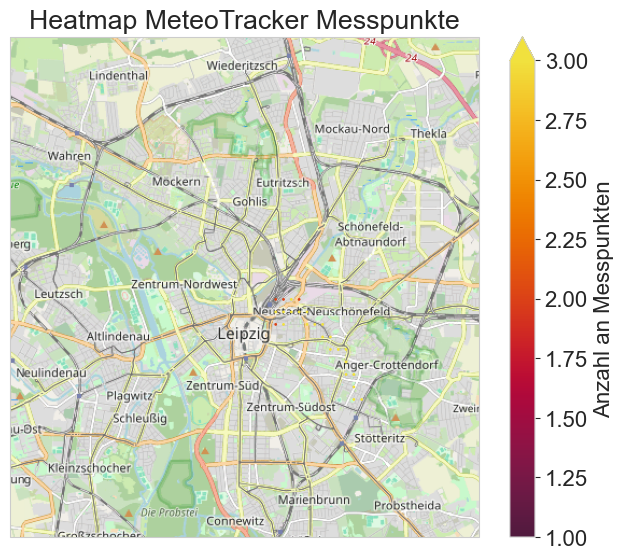

In [76]:
df_verteilung = df.groupby(['group_lon', 'group_lat'], as_index=False).agg(dict(air_temperature='count'))
df_verteilung.rename(columns={'air_temperature': 'points', 'group_lon': 'lon', 'group_lat': 'lat'}, inplace=True)

# %% plot temperature on map and add a nice colourbar
cmap = cm.get_sub_cmap(cm.ember, 0.25, 1)
plt.rc("font", size=16)
plot_df = df_verteilung  # [::100]  # subsample dataframe if needed
request = cimgt.OSM()
fig, ax = plt.subplots(figsize=(8, 6.5), subplot_kw=dict(projection=request.crs))
ax.set_extent(extent)
ax.add_image(request, 12)
scatter = ax.scatter(plot_df["lon"], plot_df["lat"], 
                     c=plot_df["points"], 
                     transform=ccrs.Geodetic(), 
                     s=1,
                     cmap=cmap, 
                     vmax=plot_df["points"].quantile(0.95))
cbar = plt.colorbar(scatter, ax=ax, orientation="vertical", label="Anzahl an Messpunkten", extend="max")
ax.set_title("Heatmap MeteoTracker Messpunkte")
plt.show()
plt.close()


## Interpolation auf grid

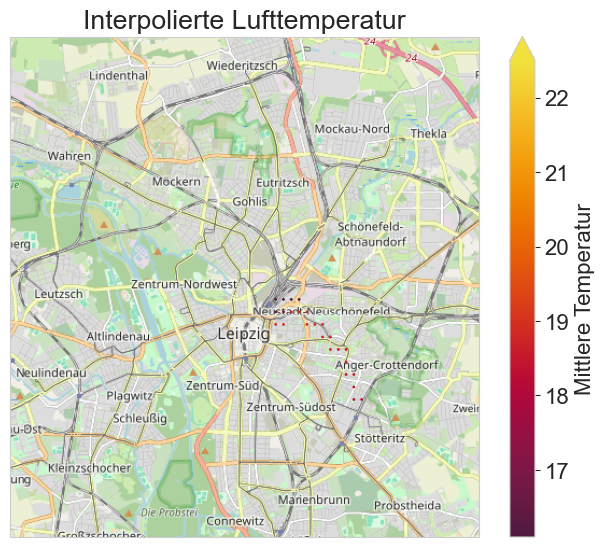

In [78]:
df_verteilung = df.groupby(['group_lon', 'group_lat'], as_index=False).agg(dict(air_temperature='mean'))
df_verteilung.rename(columns={'air_temperature': 'points', 'group_lon': 'lon', 'group_lat': 'lat'}, inplace=True)

# %% plot temperature on map and add a nice colourbar
cmap = cm.get_sub_cmap(cm.ember, 0.25, 1)
plt.rc("font", size=16)
plot_df = df_verteilung  # [::100]  # subsample dataframe if needed
request = cimgt.OSM()
fig, ax = plt.subplots(figsize=(8, 6.5), subplot_kw=dict(projection=request.crs))
ax.set_extent(extent)
ax.add_image(request, 12)
scatter = ax.scatter(plot_df["lon"], plot_df["lat"], 
                     c=plot_df["points"], 
                     transform=ccrs.Geodetic(), 
                     s=1,
                     cmap=cmap, 
                     vmax=plot_df["points"].quantile(0.95))
cbar = plt.colorbar(scatter, ax=ax, orientation="vertical", 
                    label="Mittlere Temperatur", extend="max")
ax.set_title("Interpolierte Lufttemperatur")
plt.show()
plt.close()
